In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pdb

# 0. Load data

Functions to load data:

In [2]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, [size,size])
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x=0
    
    for path in sorted(glob.glob(root_path)):
        if 'Zone.Identifier' in path:
            continue
        else:
            image = load_image(path, size)
            
            if 'mask' in path:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
                image = image/255.
                if x:
                    masks[-1] += image
                    masks[-1] = np.array(masks[-1]>.5, dtype='float64')
                else:
                    masks.append(image)
                    x = 1
            else:
                image = image/255.
                images.append(image)
                x=0
    return np.array(images), np.array(masks)

Load data:

In [3]:
root_path = 'data/images/*/*'
size=128

X, y = load_data(root_path, size)


# 1. EDA

In [4]:
categories = ['benign', 'malignant', 'normal']
dict = {}
for category in categories:
    dict[category] = [
        path for path in sorted(glob.glob(f'data/images/{category}/*')) if ('Zone.Identifier' not in path) and ('mask' not in path)
    ]


In [5]:
benign_len = len(dict['benign'])
malignant_len = len(dict['malignant'])
normal_len = len(dict['normal'])
all_len = benign_len + malignant_len + normal_len

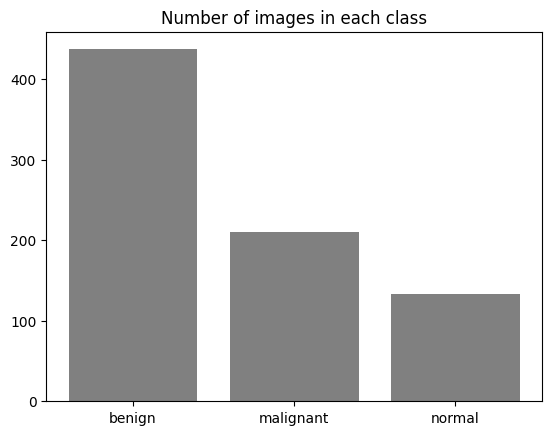

In [6]:
plt.bar(categories, [benign_len, malignant_len, normal_len], color='grey')
plt.title('Number of images in each class')
plt.show()

In [7]:
import tensorflow as tf

2023-05-26 20:42:41.136451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 20:42:42.275501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saori/.pyenv/versions/3.10.6/envs/breast-ultrasound/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-26 20:42:42.275531: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-26 20:42:42.401852: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory f

2023-05-26 20:42:51.809890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saori/.pyenv/versions/3.10.6/envs/breast-ultrasound/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-26 20:42:51.810842: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-26 20:42:51.810930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Chau): /proc/driver/nvidia/version does not exist
2023-05-26 20:42:51.826111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

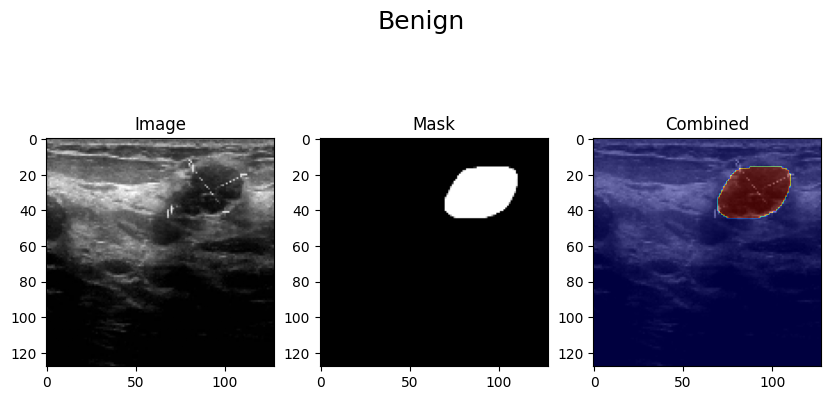

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Benign', fontsize=18)

i = np.random.randint(0, benign_len)

axs[0].imshow(X[i])
axs[0].set_title('Image')

axs[1].imshow(y[i], cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(X[i])
axs[2].imshow(tf.squeeze(y[i]), alpha=.5, cmap='jet')
axs[2].set_title('Combined')

plt.show()


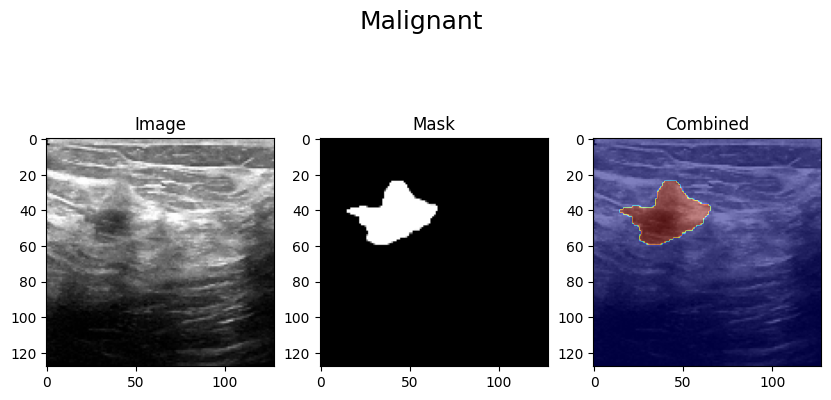

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Malignant', fontsize=18)

i = np.random.randint(benign_len, benign_len+malignant_len)

axs[0].imshow(X[i])
axs[0].set_title('Image')

axs[1].imshow(y[i], cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(X[i])
axs[2].imshow(tf.squeeze(y[i]), alpha=.5, cmap='jet')
axs[2].set_title('Combined')

plt.show()


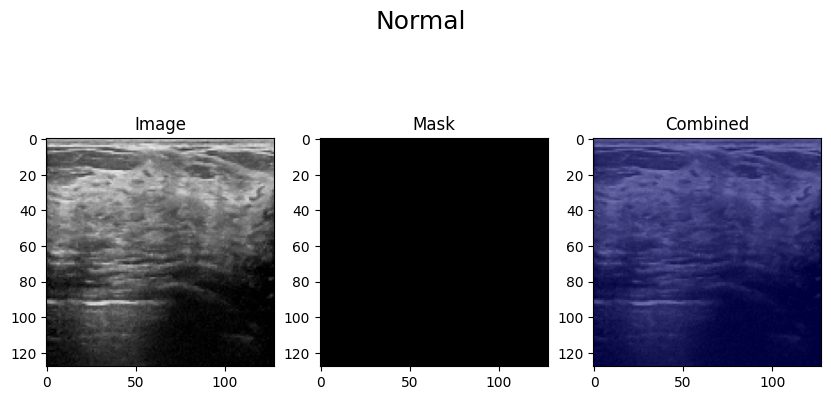

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Normal', fontsize=18)

i = np.random.randint(benign_len+malignant_len, all_len)

axs[0].imshow(X[i])
axs[0].set_title('Image')

axs[1].imshow(y[i], cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(X[i])
axs[2].imshow(tf.squeeze(y[i]), alpha=.5, cmap='jet')
axs[2].set_title('Combined')

plt.show()


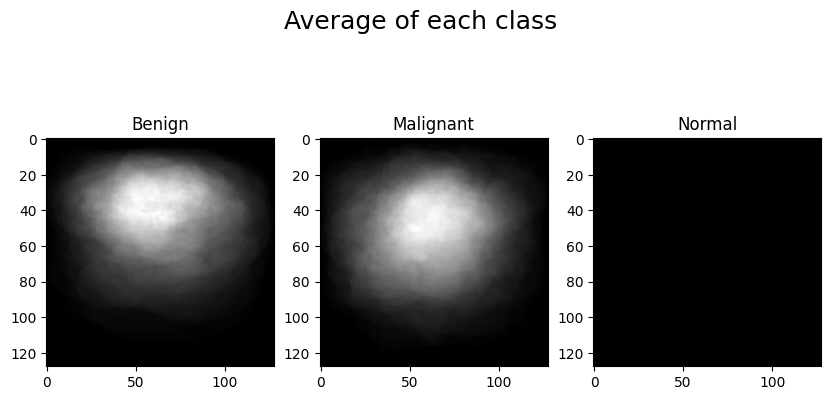

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Average of each class', fontsize=18)

axs[0].imshow(sum(y[0:benign_len])/benign_len, cmap='gray')
axs[0].set_title('Benign')

axs[1].imshow(sum(y[benign_len:benign_len+malignant_len])/malignant_len, cmap='gray')
axs[1].set_title('Malignant')

axs[2].imshow(sum(y[benign_len+malignant_len:all_len])/normal_len, cmap='gray')
axs[2].set_title('Normal')

plt.show()


# 2. Data prep for models

In [12]:
# X = np.expand_dims(X, -1) # MobileNet requires 3 dimensions
y = np.expand_dims(y, -1)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (780, 128, 128, 3), y shape: (780, 128, 128, 1)


split train set, val set and test set

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5)

print(
    f"X train: {X_train.shape}, X val: {X_val.shape}, X test: {X_test.shape}, \
    y train: {y_train.shape}, y val: {y_val.shape}, y test: {y_test.shape}"
    )

X train: (624, 128, 128, 3), X val: (78, 128, 128, 3), X test: (78, 128, 128, 3),     y train: (624, 128, 128, 1), y val: (78, 128, 128, 1), y test: (78, 128, 128, 1)


# 3. Image segmentation model building

#### Building from scratch

In [15]:
def conv_block(input, n_filters, block_num):
    conv = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu', name=f'seg_c{block_num}_1')(input)
    conv = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu', name=f'seg_c{block_num}_2')(conv)
    return conv
    

In [16]:
def downsample_block(input, n_filters, block_num):
    conv = conv_block(input, n_filters, block_num)
    p = tf.keras.layers.MaxPool2D((2,2), padding='same', name=f'seg_p{block_num}')(conv)
    p = tf.keras.layers.Dropout(.1, name=f'seg_p{block_num}_do')(p)
    return conv, p

In [17]:
def upsample_block(input, conv_features, n_filters, block_num):
    up = tf.keras.layers.Conv2DTranspose(n_filters, (2,2), (2,2), padding='same', activation='relu', name=f'seg_u{block_num}')(input)
    concat = tf.keras.layers.concatenate([up, conv_features], name=f'seg_u{block_num}_concat')
    do = tf.keras.layers.Dropout(.1, name=f'seg_u{block_num}_do')(concat)
    conv = conv_block(do, n_filters, block_num)
    return conv

In [18]:
inputs = tf.keras.Input(shape=(128, 128, 3), name='seg_inputs')

# encoder
c1, p1 = downsample_block(inputs, 16, 1)
c2, p2 = downsample_block(p1, 32, 2)
c3, p3 = downsample_block(p2, 64, 3)
c4, p4 = downsample_block(p3, 128, 4)

# bottleneck
c5 = conv_block(p4, 256, 5)

# decoder
c6 = upsample_block(c5, c4, 128, 6)
c7 = upsample_block(c6, c3, 64, 7)
c8 = upsample_block(c7, c2, 32, 8)
c9 = upsample_block(c8, c1, 16, 9)

# output
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

# put model together
seg_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
seg_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seg_inputs (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 seg_c1_1 (Conv2D)              (None, 128, 128, 16  448         ['seg_inputs[0][0]']             
                                )                                                                 
                                                                                                  
 seg_c1_2 (Conv2D)              (None, 128, 128, 16  2320        ['seg_c1_1[0][0]']               
                                )                                                             

#### From tf tutorial

In [19]:
mn_model = tf.keras.applications.MobileNetV2(
    input_shape = (128, 128, 3), include_top=False
)


In [20]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

mn_model_outputs = [mn_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=mn_model.input, outputs=mn_model_outputs)
down_stack.trainable = False

In [21]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(216, 3),
    pix2pix.upsample(127, 3),
    pix2pix.upsample(64, 3)
]

In [22]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # downsampling
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x) 
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # last layer
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same'
    )
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# 4. Model training

In [23]:
es = tf.keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

In [24]:
EPOCHS = 100

model_history = seg_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=EPOCHS,
    callbacks=[es],
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
39/39 [==============================] - 125s 3s/step - loss: 0.3789 - accuracy: 0.9178 - val_loss: 0.3088 - val_accuracy: 0.9081
Epoch 2/100
39/39 [==============================] - 128s 3s/step - loss: 0.2777 - accuracy: 0.9217 - val_loss: 0.3157 - val_accuracy: 0.9081
Epoch 3/100
39/39 [==============================] - 130s 3s/step - loss: 0.2412 - accuracy: 0.9217 - val_loss: 0.2482 - val_accuracy: 0.9081
Epoch 4/100
39/39 [==============================] - 131s 3s/step - loss: 0.2033 - accuracy: 0.9246 - val_loss: 0.2405 - val_accuracy: 0.9081
Epoch 5/100
39/39 [==============================] - 143s 4s/step - loss: 0.1952 - accuracy: 0.9268 - val_loss: 0.2181 - val_accuracy: 0.9174
Epoch 6/100
39/39 [==============================] - 143s 4s/step - loss: 0.2091 - accuracy: 0.9250 - val_loss: 0.2556 - val_accuracy: 0.9081
Epoch 7/100
39/39 [==============================] - 132s 3s/step - loss: 0.2060 - accuracy: 0.9217 - val_loss: 0.2387 - val_accuracy: 0.9081
Epoch 

In [25]:
import json
history_dict = model_history.history
json.dump(history_dict, open("training/training_2.json", 'w'))

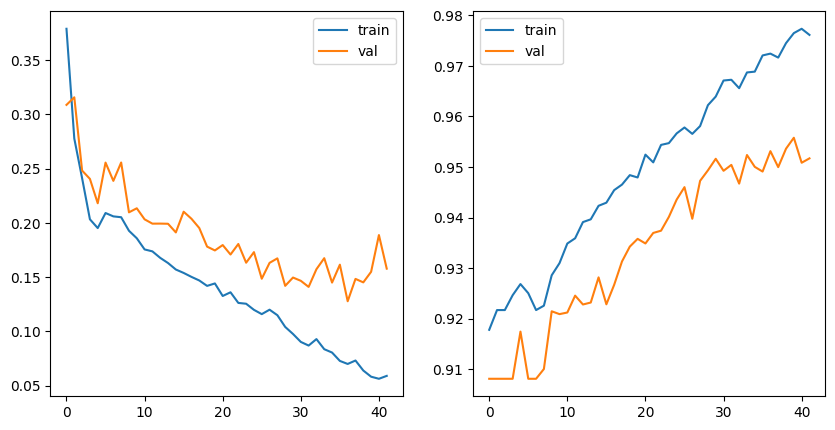

In [26]:
history_dict.keys()
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(history_dict['loss'], label="train")
axs[0].plot(history_dict['val_loss'], label="val")
axs[1].plot(history_dict['accuracy'], label="train")
axs[1].plot(history_dict['val_accuracy'], label="val")
axs[0].legend()
axs[1].legend()


In [27]:
seg_model.save('models/model_02.h5')

#### from tf tutorial

In [28]:
# OUTPUT_CLASSES = 2

# model = unet_model(output_channels = OUTPUT_CLASSES)
# model.compile(
#     optimizer = 'adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy'],
# )

In [29]:
# sample_image, sample_mask = X[0], y[0]

In [30]:
# def create_mask(pred_mask):
#   pred_mask = tf.math.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[..., tf.newaxis]
#   return pred_mask[0]

In [31]:
# def show_predictions(dataset=None, num=1):
#   if dataset:
#     for image, mask in dataset.take(num):
#       pred_mask = model.predict(image)
#       display([image[0], mask[0], create_mask(pred_mask)])
#   else:
#     display([sample_image, sample_mask,
#              create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [32]:
# es = tf.keras.callbacks.EarlyStopping(
#     patience=5,
#     verbose=1,
#     restore_best_weights=True,
# )

In [33]:
# EPOCHS = 100

# model_history = model.fit(
#     X_train, y_train,
#     batch_size=16,
#     epochs=EPOCHS,
#     callbacks=[es],
#     validation_data=(X_val, y_val),
#     verbose=1
# )

In [34]:
# import json
# history_dict = model_history.history
# json.dump(history_dict, open("training/training_1.json", 'w'))

In [35]:
# history_dict.keys()
# fig, axs = plt.subplots(1, 2, figsize=(10,5))
# axs[0].plot(history_dict['loss'], label="train")
# axs[0].plot(history_dict['val_loss'], label="val")
# axs[1].plot(history_dict['accuracy'], label="train")
# axs[1].plot(history_dict['val_accuracy'], label="val")
# axs[0].legend()
# axs[1].legend()


In [36]:
# model.save('models/model_01.h5')